<a href="https://colab.research.google.com/github/svandergoote/LGBIO2060-2022/blob/main/LGBIO2060_TP6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LGBIO2060 Exercise session 6

# Optimal control of a discrete variable

__Authors:__ Simon Vandergooten, Clémence Vandamme

__Content inspired from__: Neuromatch Academy github.com/NeuromatchAcademy

---
# Tutorial Objectives

In this tutorial, we will implement a **binary control** task: a Partially Observable Markov Decision Process (POMDP) that describes fishing. The agent (you) seeks reward from two fishing sites without directly observing where the school of fish is. This makes the world a Hidden Markov Model (HMM). Based on when and where you catch fish, you keep updating your belief about the fish location, i.e., the posterior of the fish given past observations. You should control your position to get the most fish while minimizing the cost of switching sides.

You've already learned about stochastic dynamics, latent states, and measurements. Now we introduce **actions**, based on the new concepts of **control, utility, and policy**. This general structure provides a foundational model for the brain's computations because it includes a perception-action loop where the animal can gather information, draw inferences about its environment, and select actions with the greatest benefit.

In this tutorial, you will:
* Use the Hidden Markov Models you learned about previously to model the world state.
* Use the observations (fish caught) to build beliefs (posterior distributions) about the fish location.
* Evaluate the quality of different control policies for choosing actions.
* Discover the policy that maximizes utility.

---
## Setup



In [ ]:
# Imports
import numpy as np
from math import isclose
import matplotlib.pyplot as plt

In [ ]:
#@title Plotting functions
def plot_states(S):
  # 0 represents left and 1 right
  n = np.size(S)
  X = np.arange(n)
  label = ["left", "right"]

  ax = plt.subplot(1, 1, 1)
  ax.plot(X,S)
  ax.set_title('Evolution of the fish location')
  ax.set_xlabel('Time')
  ax.set_ylabel('Location')
  ax.set_yticks(np.array([0, 1]))
  ax.set_yticklabels(label)

def plot_fishingSituation(S, my_side, M):
  # We will add stars if we caught a fish
  n = np.size(S)
  X = np.arange(n)

  ax = plt.subplot(1, 1, 1)
  ax.plot(X,S)
  ax.set_title('Evolution of the fish location')
  ax.set_xlabel('Time')
  ax.set_ylabel('Location')
  ax.set_yticks(np.array([0, 1]))
  ax.set_yticklabels(["left", "right"])

  # add symbols representing the side the fisherman is
  ax.plot(X, my_side,'o', label='my side',markersize=2)
  ax.legend(loc="upper right")

  # add stars representing fish catch
  idx = np.where(M == 1)
  ax.plot(X[idx], my_side[idx], 'r*',label='catch')
  ax.legend(loc="upper right")


def plot_Policy(S,belief, my_side, M, threshold,actions):
  # First subplot will be the evolution of the belief
  n = np.size(S)
  X = np.arange(n)
  n_show = 50
  ax = plt.subplot(2, 1, 1)
  ax.plot(X[:n_show],belief[0,:n_show])
  ax.set_title('Evolution of the belief about the right side')
  ax.set_xlabel('Time')
  ax.set_ylabel('Belief')

  ax.plot(X[:n_show],np.repeat(threshold,n_show),label='Threshold')
  # Stars for actions
  idx = np.where(np.array(actions[:n_show]) == "switch")
  # we keep only the switch associated to right to left
  idx_right = np.where(np.array(my_side[:n_show]) == 1)
  idx = np.intersect1d(idx, idx_right)
  X_restricted = X[:n_show]
  ax.plot(X_restricted[idx],np.repeat(threshold,np.size(idx)), 'r*',label='switch')
  ax.legend(loc='lower right')

  # Are we on the same side as the fishes ?
  ax = plt.subplot(2, 1, 2)
  ax.plot(X[:n_show], S[:n_show], label='fish')
  ax.plot(X[:n_show], my_side[:n_show],'o', label='my side',markersize=2)
  ax.legend(loc="center right")
  ax.set_xlabel('Time')
  ax.set_ylabel('Location')
  ax.set_yticks(np.array([0, 1]))
  ax.set_yticklabels(["left", "right"])

---
# Section 1: Analyzing the Problem

**Problem Setting**

*1. State dynamics:* There are two possible locations for the fish: Left and Right. Secretly, at each time step, the fish may switch sides with a certain probability $p_{\rm sw} = 1 - p_{\rm stay}$. This is the binary switching model. The fish location, $s^{\rm fish}$, is latent; you get measurements about it when you try to catch fish. This gives you a *belief* or posterior probability of the current location given your history of measurements.

*2. Actions:* Unlike past practical sessions, you can now **act** on the process! You may stay on your current location (Left or Right), or switch to the other side.

*3. Rewards and Costs:* You get rewarded for each fish you catch (one fish is worth 1 "point"). If you're on the same side as the fish, you'll catch more, with probability $q_{\rm high}$ per discrete time step. Otherwise, you may still catch some fish with probability $q_{\rm low}$. However, you pay a price of $C$ points for switching to the other side. So you better decide wisely!

<br>

**Maximizing Utility**

To decide "wisely" and maximize your total utility (total points), you will follow a **policy** that prescribes what to do in any situation. Here the situation is determined by your location and your **belief** $b_t$ (posterior) about the fish location (remember that the fish location is a latent variable).

In optimal control theory, the belief is the posterior probability over the latent variable given all the past measurements. It can be shown that maximizing the expected utility with respect to this posterior is optimal.

In our problem, the belief can be represented by a single number because the fish are either on the left or the right side. So we write:

\begin{equation}
b_t = p(s^{\rm fish}_t = {\rm Right}\  |\  m_{0:t}, a_{0:t-1})
\end{equation}

where $m_{0:t}$ are the measurements and $a_{0:t-1}$ are the actions (stay or switch).

Finally, we will parameterize the policy by a simple threshold on beliefs: when your belief that fish are on your current side falls below a threshold $\theta$, you switch to the other side.

You will discover that if you pick the right threshold, this simple policy happens to be optimal!

## State dynamics

Let's start by defining the HMM that describes the fish dynamics. \\
When $s = 0$, the school of fish is on the **left** side; when $s=1$, the school of fish is on the **right** side.  

[0. 0. 1. 1. 1.]


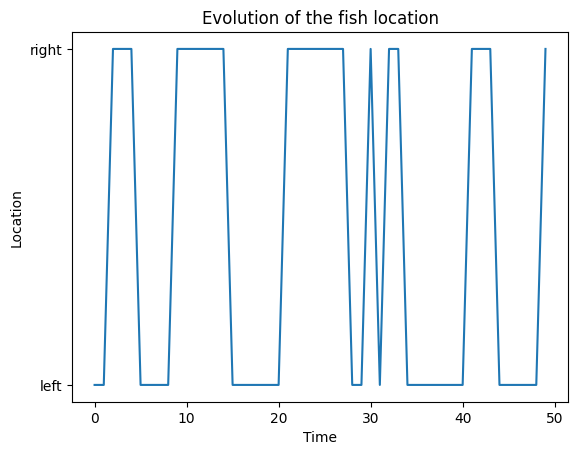

In [ ]:
def generate_state(switch_proba, start_proba, n_states):
  '''
  Create an HMM binary state variable.
  Args:
    switch_proba (array): the probabilities to switch from states. [rightToLeft, LeftToRight]
    start_proba (array): the initial probabilities of being on each side. [p_right, p_left]
    n_states (int): the number of time steps

  Returns:
    S (array): the vector of state for each time step.
  '''
  ##########################
  ##### Your code here #####
  ##########################
  #Initialize S
  S = np.zeros(n_states)

  #Step 1: Initial state (Hint: np.random.choice)
  S[0] = ...

  #Step 2: Transition matrix
  T = ...

  #Step 3: Iterate on each time step to find the new state s[t] based on S[t-1]



  return S

#Set random seed
np.random.seed(54)

#Set parameters of HMM
switch_proba = np.array([0.2, 0.2])
start_proba = np.array([0, 1]) #The initial state is left (0)
n_states = 50

#Generate the hidden states vector
S = generate_state(switch_proba, start_proba, n_states)

#Plot state evolution
plot_states(S)

---
# Section 2: Catching fish

Now that we have created the hidden states, i.e., the true position of the fish, you will create the binary measurements vector *M* from it.

Recall that in reality we don't have access to the hidden states but only to noisy measurements that give us information about those hidden states we want to infer.

You will implement the function `sample` that generates one sample $m_t$ based on the hidden state $s_t$ and the side you are fishing $side_t$.
- $m_t=0$ if no catch and 1 if catch
- If you're on the same side as the fish you have a *high* probability of reward  to catch one fish, and a *low* probability of reward otherwise. Note that therefore, these two probabilities must not necesserality sum to 1, why ?





[0. 1. 0. 0. 0.]


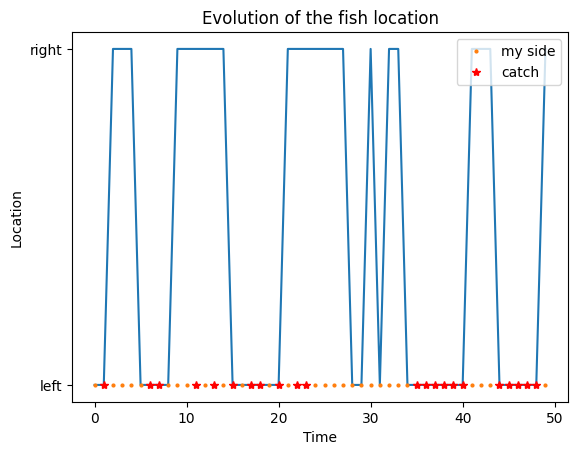

In [ ]:
def sample(S, rewards_prob, my_side):
  '''
  Create a binary measurement from HMM states

    Args:
      S (int): The hidden state, i.e. the side of the school of fishes (0 if left, 1 if right)
      rewards_prob (array): [high low], with high (low) being the probability of catching a fish when you are on the correct (wrong) side.
      my_side (int): Your side (0 if left, 1 if right)

    Returns:
      M (int): The binary measurements (1 if you catch a fish; 0 if not).
  '''
  ##########################
  ##### Your code here #####
  ##########################


  return M


np.random.seed(56)
rewards_prob = np.array([0.8, 0.1])
# Lazy strategy : we stay always on the left side
my_side = np.zeros_like(S)

#Generate the measurements vector M
M = np.zeros_like(S)
for t in range(len(S)):
  M[t] = sample(S[t], rewards_prob, my_side[t])


plot_fishingSituation(S, my_side, M)

---
# Section 3: Belief dynamics and belief distributions

We can now compute the belief about the fish location thanks to our measurement, i.e. did we catch a fish or not, and our prior knowledge of the HMM dynamics.
In this exercice, you will implement the function *belief_update* that updates the posterior probability about the fish's location given our measurements $p(s_t|m_{0:t})$.

To compute the likelihood, remember that it corresponds to the probability of getting a specific measurement given a latent state. To compute the posterior probability at the instant *t* of the fishes being left (resp. right), you need compute the probability of getting $m_t$ given that the school of fish is on the left (right) side.  

In [ ]:
def belief_update(belief_past, my_side, M, switch_proba, rewards_prob):
    """
    using PAST belief on the LEFT box, CURRENT location and
        and measurement to update belief

    Args:
      belief_past (array): p(s_{t-1}|m_{1:t-1}), [right left].
      my_side : 0 if left, 1 if right.
      M : 1 if a fish was catched.
      switch_proba (array): the probabilities to switch from states. [rightToLeft, LeftToRight]
      rewards_prob (array): [high, low]
    Returns:
      belief (array): p(s_{t}|m_{1:t}), [right left].

    """
    #Transition matrix
    T = ...

    # Update prior
    prediction = ...

    # Get the likelihood


    # Compute posterior
    belief = ...

    #Normalize

    return belief

---
# Section 4: Implementing a threshold policy

Now we'll switch the policy from the 'lazy' policy (always staying on the same side) used above to a threshold policy. You'll change your location whenever your belief is low enough that you're on the correct side. You'll update the function `policy_threshold(threshold, belief, loc)`. This policy takes three inputs and will return the optimal action:

1. The `belief` about the fish state. For convenience, we will represent the belief at time *t* using a 2-dimensional vector. The first element is the belief that the fish are on the right, and the second element is the belief the fish are on the left. At every time step, these elements sum to 1.

2. Your location `my_side`, represented as "Left" = 0 and "Right" = 1.

3. A belief `threshold` that determines when to switch. When your belief that you are on the same side as the fish drops below this threshold, you should move to the other location, and otherwise stay.

Your function should return an action for each time *t*, which takes the value of "stay" or "switch".

In [ ]:
def policy_threshold(threshold, belief, my_side):
  """
  chooses whether to switch side based on whether the belief
      on the current site drops below the threshold

  Args:
    threshold (float): the threshold of belief on the current site,
                        when the belief is lower than the threshold, switch side
    belief (numpy array of float, 2-dimensional): the belief on the
                                                  two sites at a certain time
    my_side (int) : the location of the agent at a certain time
                0 for left side, 1 for right side

  Returns:
    act (string): "stay" or "switch"
  """

  ## Hint: use my_side value to determine which row of belief you need to use

  # Write the if statement

  return act

---
# Section 5: Implementing a value function

Let's find out how good our threshold is. For that, we will calculate a **value function** that quantifies our utility (total points). We will use this value to compare different thresholds; remember, our goal is to maximize the amount of fish we catch while minimizing the effort involved in changing locations.

The value is the total expected utility per unit time.

\begin{equation}
V(\theta) = \frac{1}{T}\left( \sum_t R(s_t) - C(a_t) \right)
\end{equation}

where $R(s_t)$ is the instantaneous reward we get at side $s_t$ and $C(a_t)$ is the cost we paid for the chosen action. Remember, we receive one point for fish caught and pay `cost_sw` points for switching to the other side.

We could take this average mathematically over the probabilities of rewards and actions. However, we can get the same answer by simply averaging the _actual_ rewards and costs **over a long time**. This is what you are going to do.

In [ ]:
def get_value(rewards, actions, cost_sw):
  """
  Args:
    rewards (numpy array of length T): whether a reward is obtained (1) or not (0) at each time step
    actions (numpy array of length T): action, "stay" or "switch", taken at each time step.
    cost_sw (float): the cost of switching to the other location

  Returns:
    value (float): expected utility per unit time
  """
  cost =0


  # Calculate the value function
  value = ...

  return value


#Section 6 : Putting everything together

Using the functions you defined earlier, complete the function `run_policy` that returns a total utility for a given threshold.


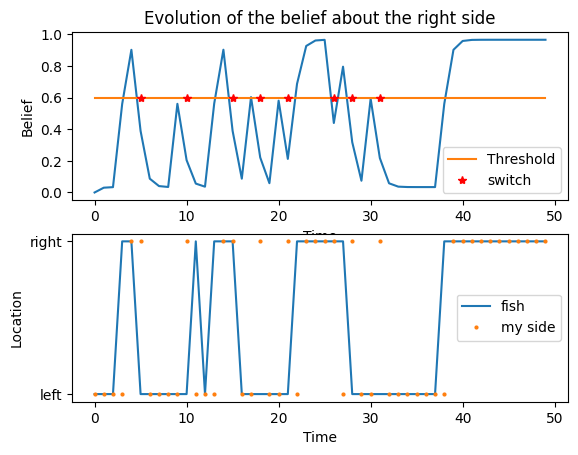

In [ ]:
def run_policy(threshold, switch_proba, start_proba, rewards_prob, my_initial_side, n_steps):
  """
  This function executes the policy (fully parameterized by the threshold) and
  returns two arrays:
    The sequence of actions taken from time 0 to T
    The sequence of rewards obtained from time 0 to T
  """
  # Simulate the latent state


  return S, M, actions[1:], belief, my_side

threshold =0.6
my_initial_side = 0
n_steps = 1000
cost_switch = 2

np.random.seed(56)
S, rewards, actions, belief, my_side = run_policy(threshold, switch_proba, start_proba, rewards_prob, my_initial_side, n_steps)
# Plot
plot_Policy(S,belief, my_side, M, threshold,actions)

value = get_value(rewards, actions, cost_switch)


Now that you have a mechanism to find out how good a threshold is, we will use a brute force approach to **compute the optimal threshold**: we'll just try all thresholds, simulate the value of each, and pick the best one. Complete the function `get_optimal_threshold(p_stay, low_rew_p, high_rew_p, cost_sw)`.

**Thinking questions:**

* Try to vary some parameters and observe how will evolve the optimal threshold : switching cost, probability that the fishes switch sides, etc.


In [ ]:
def get_optimal_threshold(switch_proba, start_proba, rewards_prob, my_initial_side, n_steps, cost_sw):
  """
  Args:
    p_stay (float): probability of fish staying in their current location
    low_rew_p (float): probability of catching fish when you and the fist are in different locations.
    high_rew_p (float): probability of catching fish when you and the fist are in the same location.
    cost_sw (float): the cost of switching to the other location

  Returns:
    value (float): expected utility per unit time
  """

  # Create an array of 20 equally distanced candidate thresholds (min = 0., max=1.):
  threshold_array = ...

  # Using the function get_value() and run_policy that you coded before and compute the value of your
  # candidate thresholds:

  # Create an array to store the value of each of your candidates:
  value_array = ...


  # Find the threshold that maximize the reward
  optimal_thresh = ...

  return threshold_array, value_array, optimal_thresh


# Feel free to change these parameters
low_rew_prob = 0.1     # Even if fish are somewhere else, you can catch some fish with probability low_rew_prob
high_rew_prob = 0.7    # When you and the fish are in the same place, you can catch fish with probability high_rew_prob
rewards_prob = np.array([high_rew_prob, low_rew_prob])
cost_sw = 0.1         # When you switch locations, you pay this cost: cost_sw


# Visually determine the threshold that obtains the maximum utility.
# Remember, policies are parameterized by a threshold on beliefs:
# when your belief that the fish are on your current side falls below a threshold 𝜃, you switch to the other side.
threshold_array, value_array, optimal_threshold = get_optimal_threshold(switch_proba, start_proba, rewards_prob, my_initial_side, n_steps, cost_sw)
print(optimal_threshold)